In [1]:
import nltk
import string
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import enchant

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from pymorphy2 import MorphAnalyzer
from autocorrect import Speller


nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\timmy_maks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
data = pd.read_csv("data.csv")

In [3]:
data.head()

,appeal_text,category_name
0,подъезд этаж в коридоре над висит какой то пр...,11
1,маленькмй лифт изрисован внутри,11
2,реклама на светофоре,0
3,подъезд этаж квартирный холл рааботники тсж л...,11
4,незаконная решетка на фасаде,5


# Preprocess

**Regular expressions to delete symbols**

In [165]:
pattern = "[A-Za-z0-9!#№$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

**Stop words**

In [166]:
rus_stop_words = stopwords.words("russian")

**Words that do not carry a semantic load**

In [167]:
my_stop_words = ['просить', 'санкт', 'петербург', 'фотофиксация', 'прилагаться', 'номер', 'спасибо', 'пожалуйста', 'здравствуйте', 
                 'добрый', 'день', 'ул', 'рф', 'россия', 'правительство', 'управлять', 'компания', 'суворовский',
                 'литовский', 'далее', 'закон', 'тсж', 'председатель', 'этаж', 'ленинградские', 
                 'отказываться', 'принимать', 'заявку', 'на', 'устранение', 'более', 'полугода']

districts_names = ['адмиралтейский', 'василеостровский', 'выборгский', 'калининский', 'кировский', 'колпинский',
             'красногвардейский', 'красносельский', 'кронштадтский', 'курортный', 'московский', 'невский',
             'петроградский', 'петродворцовый', 'приморский', 'пушкинский', 'фрунзенский', 'центральный']

my_stop_words += districts_names

**Autocorrection of errors in words**

In [168]:
spell = Speller('ru')

**Lemmatizator**

In [169]:
morph = MorphAnalyzer()

**Preprocess function**

In [170]:
def tokenize_sentence(sentence):
    sentence = re.sub(emoji_pattern, ' ', sentence) # deleting emojis
    sentence = re.sub(pattern, ' ', sentence) # deletung symbols
    sentence = sentence.lower() # to lower
    sentence = spell(sentence) # autocorrection of errors
    tokens = word_tokenize(sentence, language='russian') # tokenization
    tokens = [i for i in tokens if i not in rus_stop_words] # deleting stop words
    tokens = [i for i in tokens if i not in my_stop_words] # deleting my stop words
    tokens = [morph.normal_forms(token)[0] for token in tokens] # lemmatization
    tokens = [i for i in tokens if len(i) > 1] # deleting words (len(word) < 2)
    return tokens

**Clear and tokenize dataset**

In [171]:
%%time
tokenized_data = data.loc[:, ['appeal_text', 'category_name']]
tokenized_data["appeal_text"] = tokenized_data["appeal_text"].apply(tokenize_sentence)
tokenized_data.to_csv("tokenized_data.csv", index=False, header=True, encoding="utf-8-sig")

CPU times: total: 25min 44s
Wall time: 25min 47s


In [2]:
# import ast
# tokenized_data = pd.read_csv("tokenized_data.csv")
# tokenized_data['appeal_text'] = tokenized_data['appeal_text'].apply(lambda x: ast.literal_eval(x))

**Join lists in string**

In [3]:
cleared_data = tokenized_data.copy()
for i in range(cleared_data.shape[0]):
    cleared_data.iloc[i, 0] = " ".join(cleared_data.iloc[i, 0])

**Calculate the number of occurrences of each word in the all appeals**

In [4]:
def counter(texts):
    count = {}
    for list_element in texts:
        for element in list_element:
            if count.get(element, None):
                count[element] += 1
            else:
                count[element] = 1
            
    sorted_values = sorted(count.items(), key=lambda tpl: tpl[1], reverse=True)
    return dict(sorted_values)

In [5]:
count_words = counter(list(tokenized_data.iloc[:, 0]))

In [6]:
print(f"10 most rare words: {list(count_words.keys())[-10:]}")
print(f"5 most frequent words: {list(count_words.keys())[:10]}")

10 most rare words: ['тить', 'тесто', 'спорить', 'смота', 'отлов', 'относить', 'пропитка', 'сампо', 'сош', 'малюсенький']
5 most frequent words: ['мусор', 'дом', 'парадный', 'просить', 'убрать', 'этаж', 'подъезд', 'надпись', 'уборка', 'дверь']


**Train-test split**

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = list(cleared_data.iloc[:, 0])
y = list(cleared_data.iloc[:, 1])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

**Create tf-idf vectorizer**

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 3))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [13]:
X_train

<47911x9347 sparse matrix of type '<class 'numpy.float64'>'
	with 558895 stored elements in Compressed Sparse Row format>

In [14]:
X_test

<11978x9347 sparse matrix of type '<class 'numpy.float64'>'
	with 139245 stored elements in Compressed Sparse Row format>

In [15]:
X_train_part, _, y_train_part, __ = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

# Model

In [16]:
import seaborn as sns
import xgboost as xgb
import optuna
import random

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

**Selection of hyperparameters**

In [19]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        "num_parallel_tree": 1,
        'eval_metric': 'mlogloss',
        "tree_method": "gpu_hist",
        "n_jobs": 2
    }

    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train_part, y_train_part)
    y_pred = optuna_model.predict(X_test[:1000])
    balanced_accuracy = balanced_accuracy_score(y_test[:1000], y_pred)
    return balanced_accuracy

In [20]:
study = optuna.create_study(direction='maximize')

In [21]:
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.7330341264833746
  Params: 
    max_depth: 3
    learning_rate: 0.11895150329785813
    n_estimators: 459
    min_child_weight: 2
    gamma: 0.033562702124315
    subsample: 0.6574962096875409
    colsample_bytree: 0.4920812672099111
    reg_alpha: 0.0002078913371919044
    reg_lambda: 1.5139911948504841e-07


In [23]:
params = trial.params

**Model traning**

In [24]:
model = xgb.XGBClassifier(**params)

In [25]:
%%time
model.fit(X_train, y_train)

CPU times: total: 7min 27s
Wall time: 38.2 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4920812672099111, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.033562702124315, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.11895150329785813, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=459, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

**Evaluation**

In [26]:
prediction = model.predict(X_test)

In [27]:
accuracy = accuracy_score(y_test, prediction)
precision, recall, f1score = precision_recall_fscore_support(y_test, prediction, average="macro")[:3]
balanced_accuracy = balanced_accuracy_score(y_test, prediction)
cm = confusion_matrix(y_test, prediction)
print(f"Accuracy: {accuracy:.3f}, Balanced Accuracy: {balanced_accuracy:.3f}")
print()
print("The following metrics are obtained by macro-averaging")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1score:.3f}")

Accuracy: 0.917, Balanced Accuracy: 0.766

The following metrics are obtained by macro-averaging
Precision: 0.881, Recall: 0.766, F1-score: 0.815


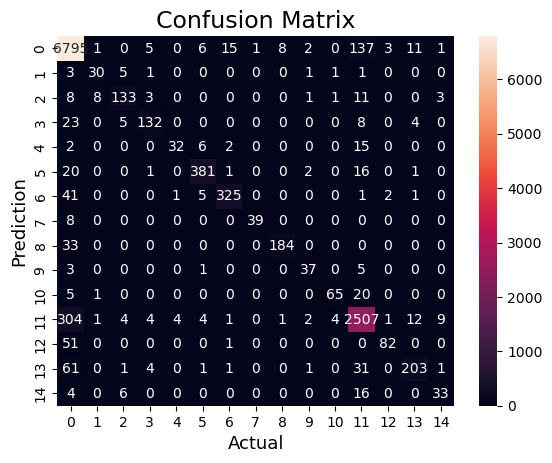

In [28]:
sns.heatmap(cm, annot=True, fmt="g")
plt.ylabel("Prediction", fontsize=13)
plt.xlabel("Actual", fontsize=13)
plt.title("Confusion Matrix", fontsize=17)
plt.show()